### Grading
This week's lab doesn't have any auto-graded components. Each question in this notebook has an accompanying Peer Review question. Although the lab shows as being ungraded, you need to complete the notebook to answer the Peer Review questions. <br>
**DO NOT CHANGE VARIABLE OR METHOD SIGNATURES** 

### Validate Button
This week's lab doesn't have any auto-graded components. Each question in this notebook has an accompanying Peer Review question. Although the lab shows as being ungraded, you need to complete the notebook to answer the Peer Review questions. 

You do not need to use the Validate button for this lab since there are no auto-graded components. If you hit the Validate button, it will time out given the number of visualizations in the notebook. Cells with longer execution times cause the validate button to time out and freeze. ***This notebook's Validate button time-out does not affect the final submission grading.*** 

# Homework 2. Stochastic Gradient Descent
***

In this assignment we'll implement a rudimentary Stochastic Gradient Descent algorithm to learn the weights in simple linear regression.  Then we'll see if we can make it more efficient.  Finally, we'll investigate some graphical strategies for diagnosing convergence and tuning parameters. 

**Note**: The cell below has some helper functions.  Scroll down and evaluate those before proceeding. 


In [1]:
!pip install pytest
import numpy as np 
import matplotlib.pylab as plt 
import pytest
%matplotlib inline

You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


In [2]:
mycolors = {"blue": "steelblue", "red":"#a76c6e",  "green":"#6a9373", "smoke": "#f2f2f2"}

def eval_RSS(X, y, b0, b1):
    rss = 0 
    for ii in range(len(df)):
        xi = df.loc[ii, "x"]
        yi = df.loc[ii, "y"]
        rss += (yi - (b0 + b1 * xi)) ** 2
    return rss

def plotsurface(X, y, bhist=None):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 300), np.linspace(-1, 5, 300))
    Z = np.zeros((xx.shape[0], yy.shape[0]))
    for ii in range(X.shape[0]):
        Z += (y[ii] - xx - yy * X[ii,1]) ** 2
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    levels = [125, 200] + list(range(400,2000,400))
    CS = ax.contour(xx, yy, Z, levels=levels)
    ax.clabel(CS, CS.levels, inline=True, fontsize=10)
    ax.set_xlim([-3,3])
    ax.set_ylim([-1,5])
    ax.set_xlabel(r"$\beta_0$", fontsize=20)
    ax.set_ylabel(r"$\beta_1$", fontsize=20)
    if bhist is not None:
        for ii in range(bhist.shape[0]-1):
            x0 = bhist[ii][0]
            y0 = bhist[ii][1]
            x1 = bhist[ii+1][0]
            y1 = bhist[ii+1][1]
            ax.plot([x0, x1], [y0, y1], color="black", marker="o", lw=1.5, markersize=5)

### Part 1: Setting Up Simulated Data and a Sanity Check 
***

We'll work with simulated data for this exercise where our generative model is given by 

$$
Y = 1 + 2X + \epsilon \textrm{ where} \epsilon \sim N(0, \sigma^2)
$$

**Part A**: The following function will generate data from the model. We'll grab a training set of size $n=100$ and a validation set of size $n = 50$.  

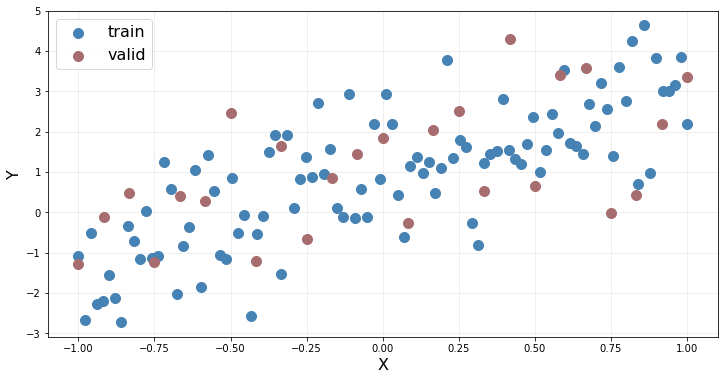

In [3]:
def dataGenerator(n, sigsq=1.0, random_state=1236):
    np.random.seed(random_state)
    x_train = np.linspace(-1, 1, n)
    x_valid = np.linspace(-1, 1, int(n / 4))
    y_train = 1 + 2 * x_train + np.random.randn(n)
    y_valid = 1 + 2 * x_valid + np.random.randn(int(n / 4))
    return x_train, x_valid, y_train, y_valid 

x_train, x_valid, y_train, y_valid = dataGenerator(100)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.scatter(x_train, y_train, color="steelblue", s=100, label="train")
ax.scatter(x_valid, y_valid, color="#a76c6e", s=100, label="valid")
ax.grid(alpha=0.25)
ax.set_axisbelow(True)
ax.set_xlabel("X", fontsize=16)
ax.set_ylabel("Y", fontsize=16)
ax.legend(loc="upper left", fontsize=16);

**Part B**: Since we're going to be implementing things ourselves, we're going to want to prepend the data matrices with a column of ones so we can fit a bias term.  We can do this using numpy's [column_stack](https://docs.scipy.org/doc/numpy/reference/generated/numpy.column_stack.html) function. 

In [4]:
X_train = np.column_stack((np.ones_like(x_train), x_train))
X_valid = np.column_stack((np.ones_like(x_valid), x_valid))

**Part C**: Finally, let's fit a linear regression model with sklearn's LinearRegression class and print the coefficients so we know what we're shooting for. 

In [5]:
from sklearn.linear_model import LinearRegression 
reg = LinearRegression(fit_intercept=False)
reg.fit(X_train, y_train)
print("sklearn says the coefficients are ", reg.coef_)

sklearn says the coefficients are  [0.90918343 2.20093262]


**Part D**: The last thing we'll do is visualize the surface of the RSS, of which we're attempting to find the minimum. Does it looks like the parameters reported by sklearn lie at the bottom of the RSS surface?  

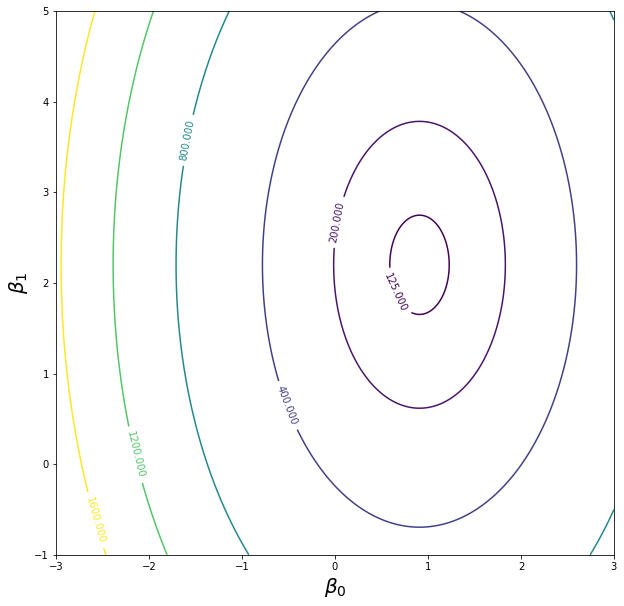

In [6]:
plotsurface(X_train, y_train)

### Part 2: Implementing and Improving SGD 
***


**Part A**: Now it's time to implement Stochastic Gradient Descent.  Most of the code in the function sgd has been written for you.  Your job is to fill in the values of the partial derivatives in the appropriate places.  Recall that the update scheme is given by 

$$
\begin{eqnarray}
\beta_0 &\leftarrow& \beta_0 - \eta \cdot 2 \cdot \left[(\beta_0 + \beta_1x_i) -y_i \right] \\
\beta_1 &\leftarrow& \beta_1 - \eta \cdot 2 \cdot \left[(\beta_0 + \beta_1x_i) -y_i \right] x_i\\
\end{eqnarray}
$$

Note that the function parameter beta is a numpy array containing the initial guess for the solve. The numpy array bhist stores the approximation of the betas after each iteration for plotting and diagnostic purposes. <br>
Look at the Peer Review assignment for a question about this section. 

In [7]:
def sgd(X, y, beta, eta=0.1, num_epochs=100):
    """
    Peform Stochastic Gradient Descent 
    
    :param X: matrix of training features 
    :param y: vector of training responses 
    :param beta: initial guess for the parameters
    :param eta: the learning rate 
    :param num_epochs: the number of epochs to run 
    """
    
    # initialize history for plotting 
    bhist = np.zeros((num_epochs+1, len(beta)))
    bhist[0,0], bhist[0,1] = beta[0], beta[1]
    
    # perform steps for all epochs 
    for epoch in range(1, num_epochs+1):
        
        # shuffle indices (randomly)
        shuffled_inds = list(range(X.shape[0]))
        np.random.shuffle(shuffled_inds)
        
        # TODO: loop over training examples, update beta (beta[0] and beta[1]) as per the above formulas
        # your code here
        for i in shuffled_inds:
            xi = X[i, 1]
            yi = y[i]
            
            pred = beta[0] + beta[1] * xi # b0 + b1x1
            err = pred - yi # yhat - y
            
            # update beta from above scheme
            beta[0] = beta[0] - eta * 2 * err
            beta[1] = beta[1] - eta * 2 * err * xi
        
        
        # save history 
        bhist[epoch, :] = beta
        
    # return bhist. Last row 
    # are the learned parameters. 
    return bhist 

In [8]:
# SGD Test for 2 features
np.random.seed(42)

mock_X = np.array([[ 1., -1.], [ 1., -0.97979798], [ 1., -0.95959596], [ 1., -0.93939394]])
mock_y = np.array([-1.09375848, -2.65894663, -0.51463485, -2.27442244])
mock_beta_start = np.array([-2.0, -1.0])

mock_bhist_exp = np.array([[-2., -1.], [-2.01174521, -0.98867152], [-2.02304238, -0.97777761], [-2.03400439, -0.96720934]])
mock_bhist_act = sgd(mock_X, mock_y, beta=mock_beta_start, eta=0.0025, num_epochs=3)

for exp, act in zip(mock_bhist_exp, mock_bhist_act):
    assert pytest.approx(exp, 0.0001) == act, "Check sgd function"

CPU times: user 184 ms, sys: 1.18 ms, total: 185 ms
Wall time: 182 ms
beta_0 = 0.91899, beta_1 = 2.20488


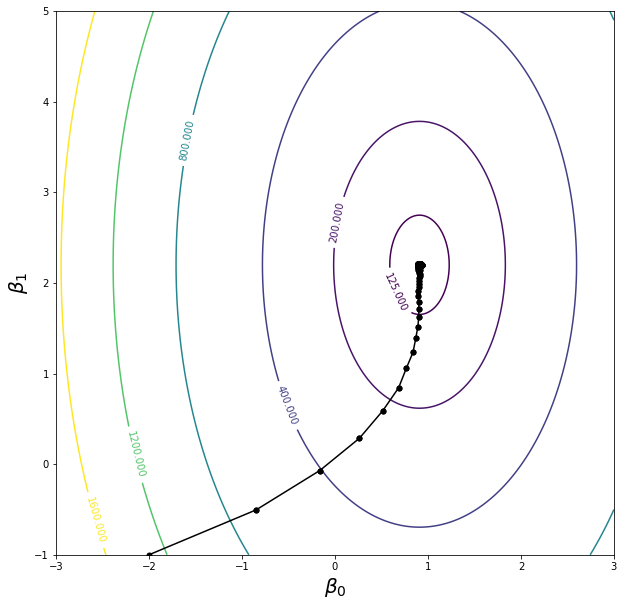

In [9]:
# Start at (-2,1)
beta_start = np.array([-2.0, -1.0])

# Training 
%time bhist = sgd(X_train, y_train, beta=beta_start, eta=0.0025, num_epochs=1000) # old = 0.0025

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

**Part B**: Thinking about the case where we have more than two features, can you think of a way to vectorize the stochastic gradient update of the parameters? When you see it, go back to the sgd function and improve it. 


In [10]:
## TODO: rewrite/modify the sgd function below. Do not modify the previous sgd function, but write a new one here. 
## Do not change the function name.
## The previous question worked for 2 features and this function is for more than 2 features so update the earlier 
# logic to work for any number of features
# your code here

def sgd(X, y, beta, eta=0.1, num_epochs=100):
    """
    Peform Stochastic Gradient Descent 
    
    :param X: matrix of training features 
    :param y: vector of training responses 
    :param beta: initial guess for the parameters
    :param eta: the learning rate 
    :param num_epochs: the number of epochs to run 
    """
    
    # initialize history for plotting 
    bhist = np.zeros((num_epochs+1, len(beta)))
    bhist[0,0], bhist[0,1] = beta[0], beta[1]
    
    # perform steps for all epochs 
    for epoch in range(1, num_epochs+1):
        
        # shuffle indices (randomly)
        shuffled_inds = list(range(X.shape[0]))
        np.random.shuffle(shuffled_inds)
        
        # TODO: loop over training examples, update beta (beta[0] and beta[1]) as per the above formulas
        # your code here
        for i in shuffled_inds:
            xi = X[i]
            yi = y[i]
            
            # same code but for any number of features
            
            pred = np.dot(xi, beta) # b0 + b1x1 and so on
            err = pred - yi # yhat - y
                        
            beta = beta - eta * 2 * err * xi

        
        
        # save history 
        bhist[epoch, :] = beta
        
    # return bhist. Last row 
    # are the learned parameters. 
    return bhist 

In [11]:
# SGD Test for more than 2 features
np.random.seed(42)

mock_X = np.array([[ 1., -1.], [ 1., -0.97979798], [ 1., -0.95959596], [ 1., -0.93939394]])
mock_y = np.array([-1.09375848, -2.65894663, -0.51463485, -2.27442244])
mock_beta_start = np.array([-2.0, -1.0])

mock_bhist_exp = np.array([[-2., -1.], [-2.01174521, -0.98867152], [-2.02304238, -0.97777761], [-2.03400439, -0.96720934]])
mock_bhist_act = sgd(mock_X, mock_y, beta=mock_beta_start, eta=0.0025, num_epochs=3)

for exp, act in zip(mock_bhist_exp, mock_bhist_act):
    assert pytest.approx(exp, 0.0001) == act, "Check sgd function"

CPU times: user 429 ms, sys: 48 ms, total: 477 ms
Wall time: 438 ms
beta_0 = 0.91899, beta_1 = 2.20488


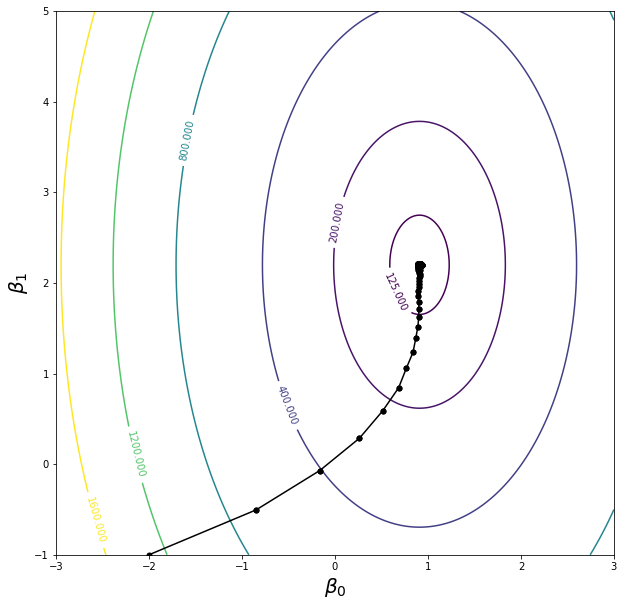

In [12]:
# Start at (-2,1)
beta_start = np.array([-2.0, -1.0])

# Training 
%time bhist = sgd(X_train, y_train, beta=beta_start, eta=0.0025, num_epochs=1000)

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

**Part C**: Now that you have created this beautiful solver, go back and break it by playing with the learning rate. Does the learning rate have the effect on convergence that you expect when visualized in the surface plot? 


beta_0 = 0.90918, beta_1 = 2.19739


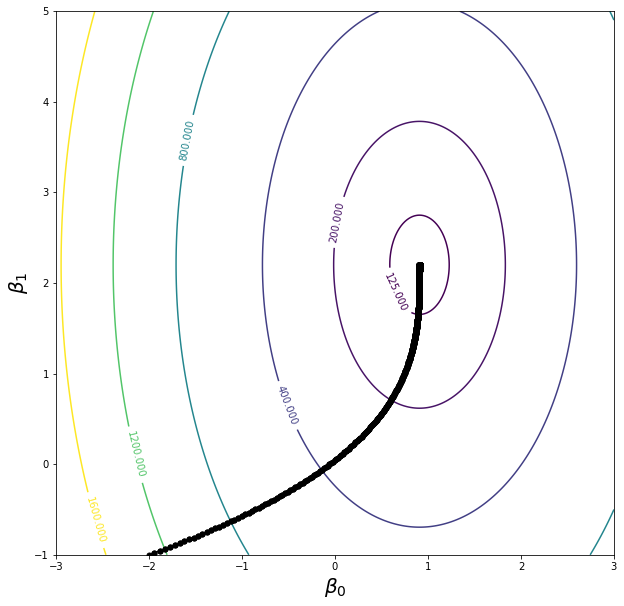

In [13]:
# Start at (-2,1)
beta_start = np.array([-2.0, -1.0])

# Training
# your code here
play_eta = 0.0001 # small learning rate
play_bhist = sgd(X_train, y_train, beta=beta_start, eta=play_eta, num_epochs=1000)


# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(play_bhist[-1][0], play_bhist[-1][1]))
plotsurface(X_train, y_train, bhist=play_bhist)

beta_0 = 0.90996, beta_1 = 2.22124


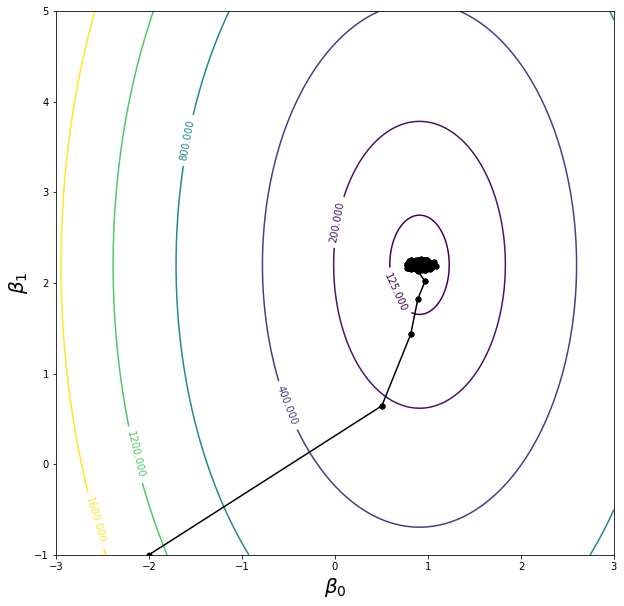

In [14]:
# Start at (-2,1)
# your code here
play_eta = 0.01 # large learning rate
play_bhist = sgd(X_train, y_train, beta=beta_start, eta=play_eta, num_epochs=1000)


# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(play_bhist[-1][0], play_bhist[-1][1]))
plotsurface(X_train, y_train, bhist=play_bhist)


beta_0 = 1.21569, beta_1 = 1.25108


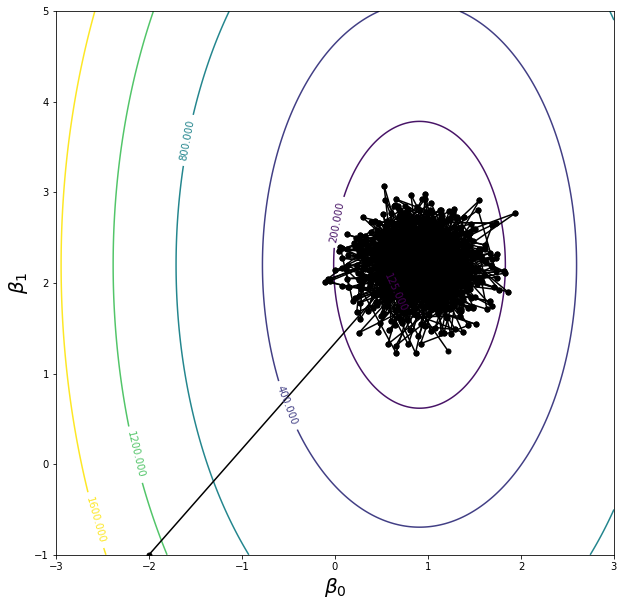

In [15]:
# Start at (-2,1)
# your code here
play_eta = 0.1 # too big learning rate
play_bhist = sgd(X_train, y_train, beta=beta_start, eta=play_eta, num_epochs=1000)


# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(play_bhist[-1][0], play_bhist[-1][1]))
plotsurface(X_train, y_train, bhist=play_bhist)

beta_0 = -0.60263, beta_1 = 2.97117


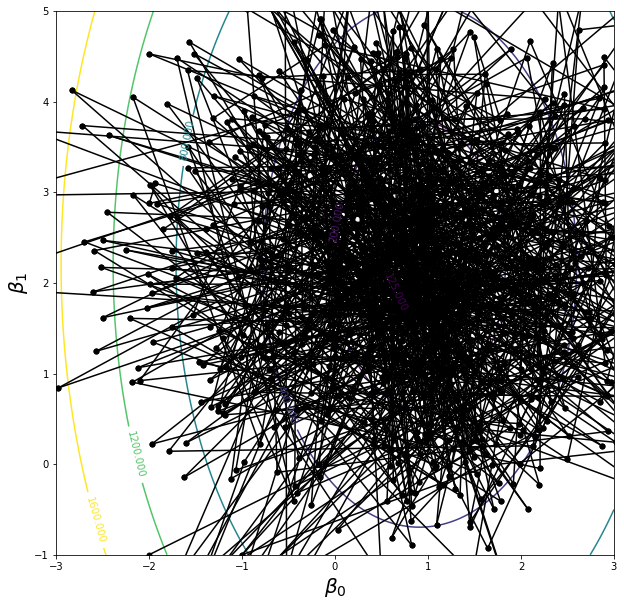

In [16]:
# Start at (-2,1)
# your code here
play_eta = 0.5 # too big learning rate
play_bhist = sgd(X_train, y_train, beta=beta_start, eta=play_eta, num_epochs=1000)


# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(play_bhist[-1][0], play_bhist[-1][1]))
plotsurface(X_train, y_train, bhist=play_bhist)

beta_0 = 0.51548, beta_1 = 0.57952


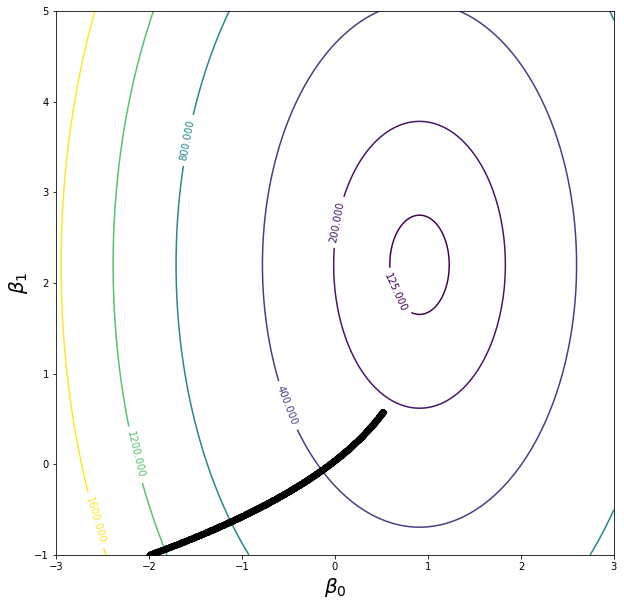

In [17]:
# Start at (-2,1)
# your code here
play_eta = 0.00001 # teeny tiny learning rate
play_bhist = sgd(X_train, y_train, beta=beta_start, eta=play_eta, num_epochs=1000)


# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(play_bhist[-1][0], play_bhist[-1][1]))
plotsurface(X_train, y_train, bhist=play_bhist)

### Part 3: Graphical Diagnosis of Convergence 
***

A common way to monitor the convergence of SGD and to tune hyperparameters (like learning rate and regularization strength) is to make a plot of how the loss function evolves during the training process. That is, we plot the value of the loss function periodically and see if it looks like it's reached a minimum, or see if it's jumping around a lot.  Normally we'd record the value of the loss function as we train, but we'll use the beta histories returned by our solver.  Finally, using the MSE instead of the RSS is a popular choice, so we'll do that.  

**Part A**: Modify the function below to take in a beta history and a data set and return a vector of MSE values for each epoch. 

In [18]:
def MSE_hist(X, y, bhist):
    mse = np.zeros(bhist.shape[0])
    for epoch in range(bhist.shape[0]):
        # TODO
        # Calculate mse for each epoch using the below formula
        # Hint: Use the standard MSE formula and tweak it to incorporate beta histories
        # your code here
        beta = bhist[epoch]
        preds = np.dot(X,beta)
        errs = preds - y
        
        mse[epoch] = np.mean(errs**2)
    
    return mse 

In [19]:
# MSE Tests
mock_X = np.array([[ 1., -1.], [ 1., -0.97979798], [ 1., -0.95959596], [ 1., -0.93939394]])
mock_y = np.array([-1.09375848, -2.65894663, -0.51463485, -2.27442244])
mock_bhist = np.array([[-2., -1.], [-2.01174521, -0.98867152], [-2.02304238, -0.97777761], [-2.03400439, -0.96720934]])

mock_mse_exp = np.array([1.1110145, 1.0840896, 1.05916951, 1.03590509])
mock_mse_act = MSE_hist(mock_X, mock_y, mock_bhist)

assert pytest.approx(mock_mse_exp, 0.0001 ) == mock_mse_act, "Check MSE_hist function" 

**Part B**: Next we'll take the MSE history that we just computed and plot it vs epoch number. Based on your plot, would you say that your MSE has converged? 

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9b3f565f10>)

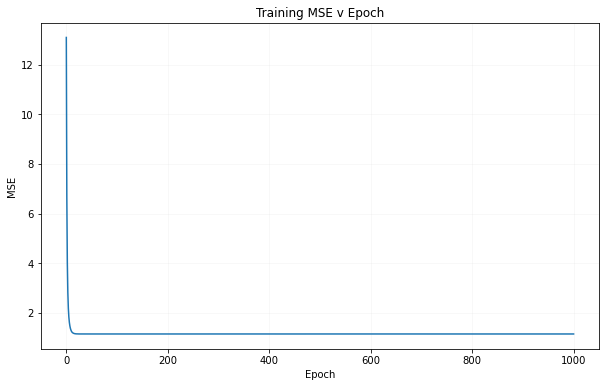

In [20]:
# plot MSE history vs. epoch number 
# your code here
def plot_MSE_hist(mse_hist):
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(range(len(mse_hist)), mse_hist)
    ax.grid(alpha=0.1)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE')
    ax.set_title('Training MSE v Epoch')
    
    return fig, ax
    
bhist = sgd(X_train, y_train, beta=beta_start, eta=0.0025, num_epochs=1000)

mse_hist = MSE_hist(X_train, y_train, bhist)
plot_MSE_hist(mse_hist)




**Part C**: Go back up and change the value of the learning rate to bigger and smaller values (you might also have to adjust the max epochs).  Do the different learning rates have the effect on the MSE plots that you would expect? 

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9b3f4e0190>)

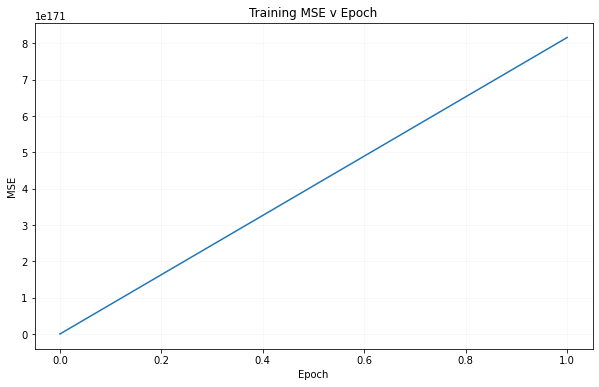

In [21]:
# TODO: change the value of the learning rate to bigger and smaller values, consider adjusting max epochs
# test plots 
# your code here
play_eta = 5
play_num_epochs = 1000
bhist = sgd(X_train, y_train, beta=beta_start, eta=play_eta, num_epochs=play_num_epochs)


mse_hist = MSE_hist(X_train, y_train, bhist)
plot_MSE_hist(mse_hist)

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9b4553b390>)

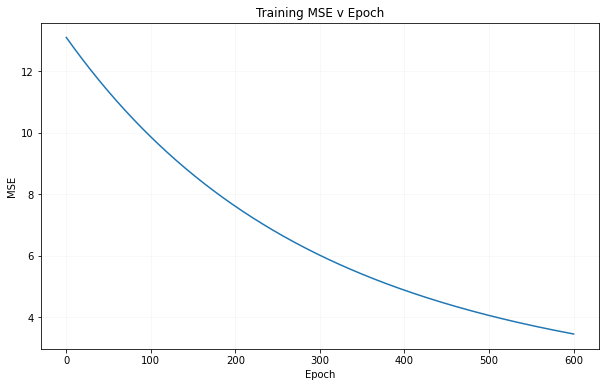

In [22]:
# continue testing plots for C 
# your code here
play_eta = 0.00001
play_num_epochs = 600
bhist = sgd(X_train, y_train, beta=beta_start, eta=play_eta, num_epochs=play_num_epochs)


mse_hist = MSE_hist(X_train, y_train, bhist)
plot_MSE_hist(mse_hist)


**Part D**: Is the MSE on the training data the best thing to look at when deciding if our training algorithm has converged? Plot the train and validation MSE as a function of epochs. Discuss the result.

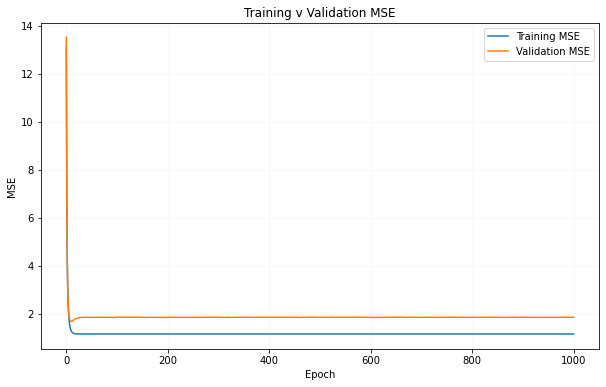

In [23]:
# plot train and validation MSE as function of epochs
# Start at (-2,1)
# your code here

bhist = sgd(X_train, y_train, beta=beta_start, eta=0.0025, num_epochs=1000)

mse_hist_train = MSE_hist(X_train, y_train, bhist)
mse_hist_valid = MSE_hist(X_valid, y_valid, bhist)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(len(mse_hist_train)), mse_hist_train, label='Training MSE')
ax.plot(range(len(mse_hist_valid)), mse_hist_valid, label='Validation MSE')
ax.grid(alpha=0.1)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.set_title('Training v Validation MSE')
ax.legend()
